In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

# DeepHit

In [2]:
df = pd.read_csv('../../data/main_process_preprocessed_data.csv')

In [3]:
# parameters
T_max = 3000
n_times = 100

In [4]:
# create dummy sex
df['sexM'] = [1 if v == 'M' else 0 for v in df.sex]
# discretise time
df['discretised_time_event'] = [int(v) for v in df.time_event/T_max*n_times]
# set features
features = ['sexM', 'age_in','ACE_PC1', 'ACE_PC2','beta_PC1', 'beta_PC2','hospitalisation_PC1', 'hospitalisation_PC2']
n_features = len(features)

## Prepare data

In [5]:
# tmp: scale now
X = pd.DataFrame(scale(df[features]),columns = features)  
y = df.discretised_time_event
status = df.status

# let's build just a validation set for the moment
X_train, X_valid,y_train, y_valid, status_train, status_valid = train_test_split(X, y, status, test_size=0.2, random_state=47)

# transform validation sets in tensors
X_valid = torch.from_numpy(X_valid.values.astype('float32'))
y_valid = torch.from_numpy(y_valid.values)
#y_valid = torch.from_numpy(y_valid.values.astype('float32'))
status_valid = torch.from_numpy(status_valid.values)

/Users/davide/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [6]:
class ColumnarDataset(Dataset):
    def __init__(self, X, y,status):
        self.dfconts = X
        
        self.conts = np.stack([c.values for n, c in self.dfconts.items()], axis=1).astype(np.float32)
        #self.y = y.values.astype(np.float32)
        self.y = y.values
        self.status = status.values
        
    def __len__(self): return len(self.y)
 
    def __getitem__(self, idx):
        return [self.conts[idx], self.y[idx], self.status[idx]]

## Define the network

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_features, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, n_times)
        self.droput = nn.Dropout(p=0.15)

    def forward(self, x):
        # TODO: add batch normalization
        x = F.relu(self.fc1(x))
        x = self.droput(x)
        x = F.relu(self.fc2(x))
        x = self.droput(x)
        x = F.softmax(self.fc3(x),dim=1)
        return x

net = Net()

# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=100, bias=True)
  (droput): Dropout(p=0.15)
)

## Define Custom loss class

In [8]:
class Surv_Loss(torch.nn.Module):  
    #def __init__(self):
     #   super(nn.CrossEntropyLoss,self).__init__()
        
    def forward(self,y_pred,y,status):
        totloss = 0
        for i in range(len(y)):    
            v = y[i]
            k = status[i]
            y_pred_i = y_pred[i,:]
            if k.item() == 1:
                totloss -= torch.log(y_pred_i[v])
            else:
                totloss -= torch.log(1-torch.sum(y_pred_i[:v]))
        return totloss

## Train

In [9]:
# build a data loader
trainds= ColumnarDataset(X_train, y_train,status_train) 
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 4}
 
train_dl = DataLoader(trainds, **params)

In [10]:
# set criterion, optimizer:
criterion = Surv_Loss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [11]:
num_batch = len(train_dl)

train_losses,valid_losses = [],[]

# train
for epoch in range(150):  # loop over the dataset multiple times
    running_loss = 0.0
    
    net.train()
    for i, data in enumerate(train_dl, 0):
        inputs, labels, status = data
        # make it use GPU, if you have it
        inputs, labels, status = inputs.to(device), labels.to(device), status.to(device) 
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels,status)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    # Evaluate on validation set
    net.eval()
    valid_pred = net(X_valid)
    valid_loss = criterion(valid_pred, y_valid,status_valid).item()
    
    train_losses.append(running_loss)
    valid_losses.append(valid_loss)
    
    if epoch % 25 == 0:    # print every 10 epochs
        print('Epoch: ',epoch,'   Training Loss: ',np.round(running_loss,2),'   Validation Loss: ',np.round(valid_loss,2))

print('Finished Training')

Epoch:  0    Training Loss:  5714.0    Validation Loss:  1341.69
Epoch:  25    Training Loss:  4989.79    Validation Loss:  1559.25
Epoch:  50    Training Loss:  4837.87    Validation Loss:  1748.72
Epoch:  75    Training Loss:  4754.95    Validation Loss:  1843.17
Epoch:  100    Training Loss:  4772.6    Validation Loss:  1827.26
Epoch:  125    Training Loss:  4771.3    Validation Loss:  1860.32
Finished Training


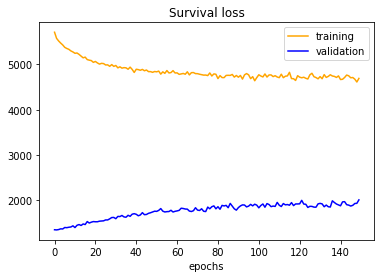

In [12]:
plt.plot(train_losses, color = 'orange', label = 'training')
plt.plot(valid_losses, color = 'blue', label = 'validation')
plt.legend()
plt.title('Survival loss')
plt.xlabel('epochs')
plt.show()